In [1]:
### JUPYTER NOTEBOOK / MODULE PATH FIX ###
import sys

if "/share/apps/python/3.8.6/intel/lib/python3.8" in sys.path and sys.path[1] == '':
    sys.path[1], sys.path[6] = sys.path[6], sys.path[1]

In [25]:
from jtb_2022_code.utils.figure_common import *
from jtb_2022_code.utils.adata_common import *
from jtb_2022_code.utils.pseudotime_common import *
from jtb_2022_code import FigureSingleCellData
from jtb_2022_code.utils.decay_common import calc_decays, calc_halflives
import numpy as np
import pandas as pd
import scanpy as sc

In [4]:
## LOAD AND PROCESS DATA ###
data = FigureSingleCellData()
#data.load_published_decay()

#def _calc_decay_for_untreated(adata, *args, **kwargs):
#    untreated = adata[(adata.obs['Pool'] == 1) | (adata.obs['Pool'] == 2), :].copy()
#    calc_decays(untreated, *args, decay_key='unperturbed_decay', alpha_key='unperturbed_alpha')
#    adata.var['unperturbed_decay'] = untreated.var['unperturbed_decay'].copy()
    
#    return adata
    
#data.apply_inplace_to_expts(_calc_decay_for_untreated)

Reading Single Cell Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_WT.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_fpr1.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_WT.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_fpr1.h5ad


In [6]:
from scipy.stats import spearmanr
import itertools
import pandas as pd

half_lives = [("Expt. 1", data.expt_data[(1, "WT")].var['unperturbed_decay']),
              ("Expt. 2", data.expt_data[(2, "WT")].var['unperturbed_decay']),
              ("Neymotin2014", data.all_data.var['Neymotin2014']),
              ("Chan2018", data.all_data.var['Chan2018']),
              ("Munchel2011", data.all_data.var['Munchel2011']),
              ("Miller2011", data.all_data.var['Miller2011']),
              ("Geisberg2015", data.all_data.var['Geisberg2015'])]

hl_spearmans = pd.DataFrame([[x[0], y[0], spearmanr(x[1], y[1], nan_policy='omit')[0]] 
                             for x, y in itertools.product(half_lives, half_lives)])

In [43]:
expt2 = data.expt_data[(2, "WT")]
expt2.obs.index.get_loc(expt2.obs.sample(1, random_state=100)

41553

In [127]:
expt2.obs.sample(1, random_state=101)

,Gene,Replicate,Pool,Experiment,n_counts,n_genes,CC,RP,RiBi,iESR,Mito,Cell Cycle,Other,Pool_Combined,program_0_time,program_1_time,program_rapa_time,program_cc_time
95954,WT,BH,3,2,5435.0,1230,S,0.378289,0.072861,0.018031,0.00092,0.086845,0.448022,3,6.871536,34.096619,6.871536,34.096619


In [71]:
expt2_denoised = data.denoised_data(2, "WT")

Loading denoised data from /scratch/cj59/RAPA/2021_RAPA_DENOISED_FIGS_2_WT.h5ad


In [76]:
expt2_denoised

AnnData object with n_obs × n_vars = 98996 × 5747
    obs: 'Gene', 'Replicate', 'Pool', 'Experiment', 'n_counts', 'n_genes', 'CC', 'RP', 'RiBi', 'iESR', 'Mito', 'Cell Cycle', 'Other', 'Pool_Combined', 'program_0_time', 'program_1_time', 'program_rapa_time', 'program_cc_time', 'denoised_leiden', 'denoised_n'
    var: 'n_cells', 'CommonName', 'G1', 'G2', 'M', 'M-G1', 'Mito', 'RP', 'RiBi', 'S', 'iESR', 'Cell Cycle', 'Other', 'category', 'programs', 'denoised_SNR', 'denoised_variance'
    uns: 'denoised', 'denoised_SNR', 'denoised_variance', 'leiden', 'log1p', 'neighbors', 'pca'
    obsm: 'denoised_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'denoised_connectivities', 'denoised_distances', 'denoised_graph', 'distances', 'noise2self_distance_graph', 'optimal_distances'

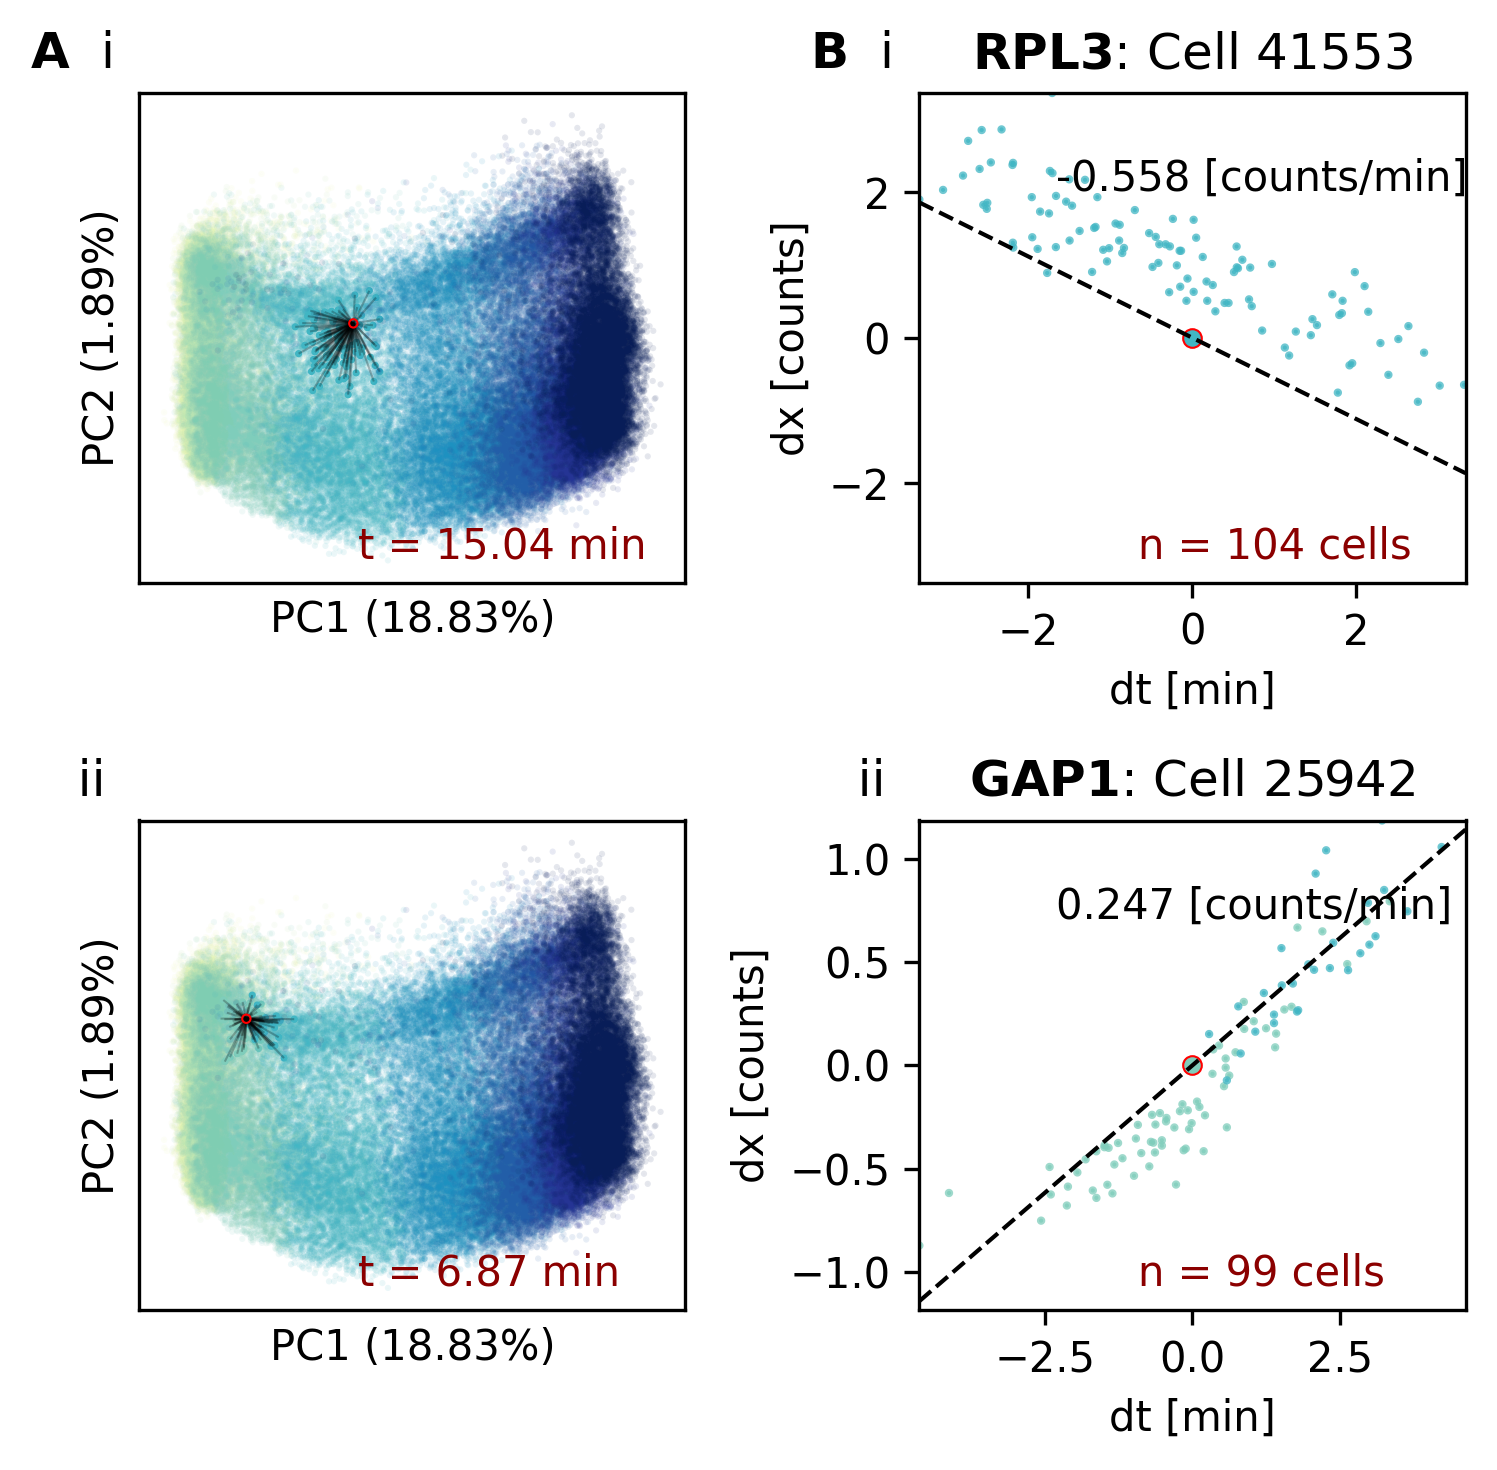

In [138]:
import matplotlib.pyplot as plt
from matplotlib import collections
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(2, 2, figsize=(5, 5), dpi=300)

def _plot_velocity_calc(
    adata,
    expr_layer,
    center,
    pca_ax=None,
    expr_ax=None,
    time_obs_key='program_0_time',
    gene="YKR039W"
):
    
    if pca_ax is None or expr_ax is None:
        fig, axs = plt.subplots(1, 2, figsize=(5, 3), dpi=300)
        pca_ax = axs[0]
        expr_ax = axs[1]
    
    else:
        fig = None
        
    connecteds = adata.obsp['noise2self_distance_graph'][center, :].nonzero()[1]
    
    alpha = np.full(adata.shape[0], 0.1)
    sizes = np.full(adata.shape[0], 0.25)

    alpha[center] = 1
    sizes[center] = 0.5

    alpha[connecteds] = 1
    sizes[connecteds] = 0.5

    pca_ax.scatter(
        adata.obsm['X_pca'][:, 0],
        adata.obsm['X_pca'][:, 1],
        c=to_pool_colors(adata.obs['Pool']),
        s=sizes,
        alpha=alpha
    )

    pca_ax.add_collection(
        collections.LineCollection(
            [(adata.obsm['X_pca'][center, 0:2], adata.obsm['X_pca'][n, 0:2]) for n in connecteds],
            colors='black',
            linewidths=0.5,
            alpha=0.25
        )
    )

    pca_ax.scatter(
        adata.obsm['X_pca'][center, 0],
        adata.obsm['X_pca'][center, 1],
        facecolors='none',
        edgecolors='r',
        linewidths=0.5,
        s=4,
        zorder=5
    )

    pca_ax.set_xlabel(f"PC1 ({adata.uns['pca']['variance_ratio'][0] * 100:.2f}%)")
    pca_ax.set_xticks([], [])
    pca_ax.set_ylabel(f"PC2 ({adata.uns['pca']['variance_ratio'][1] * 100:.2f}%)")
    pca_ax.set_yticks([], [])
    
    pca_ax.annotate(
        f"t = {adata.obs[time_obs_key].iloc[center]:0.2f} min",
        (0.40, 0.05),
        xycoords='axes fraction',
        fontsize='medium',
        color='darkred'
    )

    gene_loc = adata.var_names.get_loc(gene)
    delta_x = adata.obs[time_obs_key].iloc[connecteds] - adata.obs[time_obs_key].iloc[center]
    delta_y = expr_layer[connecteds, gene_loc] - expr_layer[center, gene_loc]
    
    lr = LinearRegression(fit_intercept=False).fit(delta_x.values.reshape(-1, 1), delta_y.reshape(-1, 1))
    slope_dxdt = lr.coef_[0][0]

    expr_ax.scatter(
        delta_x,
        delta_y,
        c=to_pool_colors(adata.obs['Pool'].iloc[connecteds]),
        s=1,
        alpha=0.75
    )

    expr_ax.scatter(
        0,
        0,
        c=to_pool_colors(adata.obs['Pool'].iloc[[center]]),
        s=20,
        edgecolors='r',
        linewidths=0.5,
    )

    expr_ax.set_title(
        r"$\bf{" + data.gene_common_name(gene) + "}$: " + f"Cell {center}"
    )
    expr_ax.set_xlabel("dt [min]")
    expr_ax.set_ylabel("dx [counts]")

    xlim = np.abs(delta_x).max()
    ylim = np.abs(delta_y).max()

    expr_ax.set_xlim(-1 * xlim, xlim)
    expr_ax.set_ylim(-1 * ylim, ylim)

    expr_ax.axline((0, 0), slope=slope_dxdt, linestyle='--', linewidth=1.0, c='black')
    expr_ax.annotate(
        f"{slope_dxdt:0.3f} [counts/min]",
        (0.25, 0.8),
        xycoords='axes fraction',
        fontsize='medium',
        color='black'
    )
    expr_ax.annotate(
        f"n = {len(connecteds)} cells",
        (0.40, 0.05),
        xycoords='axes fraction',
        fontsize='medium',
        color='darkred'
    )
    
    return fig

_plot_velocity_calc(
    expt2,
    expt2_denoised.X,
    expt2.obs.index.get_loc(expt2.obs.sample(1, random_state=100).index[0]),
    pca_ax=ax[0, 0],
    expr_ax=ax[0, 1],
    gene="YOR063W"
)

_plot_velocity_calc(
    expt2,
    expt2_denoised.X,
    expt2.obs.index.get_loc(expt2.obs.sample(1, random_state=101).index[0]),
    pca_ax=ax[1, 0],
    expr_ax=ax[1, 1],
)

ax[0, 0].set_title(r"$\bf{A}$" + "  i", loc='left', x=-0.2)
ax[0, 1].set_title(r"$\bf{B}$" + "  i", loc='left', x=-0.2)
ax[1, 0].set_title("   ii", loc='left', x=-0.2)
ax[1, 1].set_title("   ii", loc='left', x=-0.2)

fig.tight_layout()

#fig.savefig("Supplemental_Figure_3_2.png", facecolor='white')